In [2]:
import pandas as pd
import numpy as np
from data_handling import MrozHandler

FILEPATH = "data/Mroz.csv"

Mroz = MrozHandler(FILEPATH)

Number of rows: 753
Number of features: 18


In [3]:
Mroz.df.head()

,work,hoursw,child6,child618,agew,educw,hearnw,wagew,hoursh,ageh,educh,wageh,income,educwm,educwf,unemprate,city,experience
ObservationID,,,,,,,,,,,,,,,,,,
0,yes,1610,1,0,32,12,3.3540,2.65,2708,34,12,4.0288,16310,12,7,5.0,no,14
1,yes,1656,0,2,30,12,1.3889,2.65,2310,30,9,8.4416,21800,7,7,11.0,yes,5
2,yes,1980,1,3,35,12,4.5455,4.04,3072,40,12,3.5807,21040,12,7,5.0,no,15
3,yes,456,0,3,34,12,1.0965,3.25,1920,53,10,3.5417,7300,7,7,5.0,no,6
4,yes,1568,1,2,31,14,4.5918,3.60,2000,32,12,10.0000,27300,12,14,9.5,yes,7


<Axes: xlabel='ObservationID'>

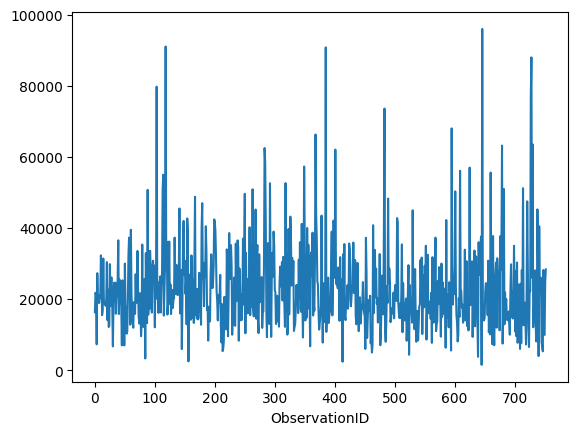

In [ ]:
Mroz.df["income"]
